### Antoine EDY
# Natural Language Processing (COMM061) - Coursework

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import nltk
from torch.utils.tensorboard import SummaryWriter

In [2]:
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [3]:
def the_preprocess(df):
    df = pd.DataFrame(df)
    # make everything lowercase
    #df["tokens"] = df["tokens"].apply(lambda x: [i.lower() for i in x])
    # lematize
    lematizer = nltk.WordNetLemmatizer()
    df["tokens"] = df["tokens"].apply(lambda x: [lematizer.lemmatize(i) for i in x])
    #stemming
    #stemmer = nltk.PorterStemmer()
    #df["tokens"] = df["tokens"].apply(lambda x: [stemmer.stem(i) for i in x])

    return df

train_dataset = the_preprocess(dataset["train"])
test_dataset = the_preprocess(dataset["test"])
val_dataset = the_preprocess(dataset["validation"])

In [4]:
import utils

train_dataset = utils.preprocess(train_dataset)
test_dataset = utils.preprocess(test_dataset)
val_dataset = utils.preprocess(val_dataset)

train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tokens     1072 non-null   object
 1   labels     1072 non-null   object
 2   ids        1072 non-null   object
 3   sentences  1072 non-null   object
dtypes: object(4)
memory usage: 33.6+ KB


In [5]:
BATCH_SIZE = 16
train_iter, val_iter, test_iter, text_field, label_field, VOCAB_SIZE = utils.init_data(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE)

In [6]:
embedding_matrix = utils.load_embeddings('glove', text_field)

Loading pre-trained embeddings
Initializing embedding matrix
torch.Size([8711, 300])


In [7]:
NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES} ({label_field.vocab.itos})")

Number of classes: 6 (['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF'])


In [8]:
import math

EMBEDDING_DIM = 300
HIDDEN_DIM = 256
NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES} : {label_field.vocab.itos}")
MAX_EPOCHS = 50
PATIENCE = 50
OUTPUT_PATH = "model_saves/bilstmtagger"
num_batches = math.ceil(len(train_dataset) / BATCH_SIZE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BiLSTMTagger = utils.BiLSTMTagger

tagger = utils.BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES, embeddings=embedding_matrix)

#train_f, dev_f = utils.train(BiLSTMTagger.to(device), train_iter, val_iter, BATCH_SIZE, MAX_EPOCHS, num_batches, PATIENCE, OUTPUT_PATH, label_field=label_field)

Number of classes: 6 : ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


BiLSTMTagger(
  (embeddings): Embedding(8711, 300)
  (lstm): LSTM(300, 256, bidirectional=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (hidden2tag): Linear(in_features=512, out_features=6, bias=True)
)
[4, 3, 5, 2] ['B-AC', 'I-LF', 'B-LF', 'B-O']
              precision    recall  f1-score   support

        B-AC       0.53      0.70      0.61       270
        I-LF       0.64      0.84      0.73       288
        B-LF       0.54      0.66      0.59       150
         B-O       0.97      0.92      0.95      4292

    accuracy                           0.90      5000
   macro avg       0.67      0.78      0.72      5000
weighted avg       0.92      0.90      0.91      5000



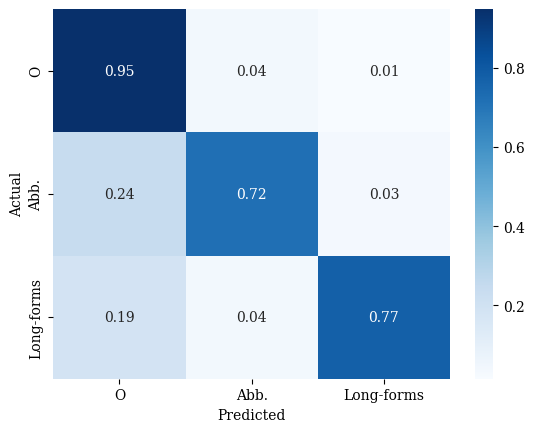

In [9]:
output_path = "model_saves/fasttext_lem"
r = utils.results(output_path, label_field, test_iter, BATCH_SIZE)